# AutoEncoder on MNIST (PyTorch) — Beginner Friendly ✅

This notebook trains a tiny **AutoEncoder** on the **MNIST** dataset, reconstructs digits, and prints the **compression ratio**. It’s written for beginners with lots of comments.

**What you’ll see:**
- A simple AutoEncoder model (fully-connected)
- Training loop on MNIST
- Reconstruction demo for one image
- Compression ratio calculation
- Clean visualizations

> Tip: No GPU required. Runs on CPU just fine.

In [1]:
# 0) Setup: imports and device selection
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Use GPU if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)


Using device: cpu


## 1) Define a Simple AutoEncoder
We use a fully-connected (MLP) autoencoder:
- **Encoder** compresses a 28×28 image (784 features) → 64-D latent vector.
- **Decoder** reconstructs 64 → 784 (back to 28×28).

In [4]:
class AutoEncoder(nn.Module):
    """
    A tiny fully-connected AutoEncoder for 28x28 grayscale images.
    - Encoder: 784 -> 128 -> 64 (latent)
    - Decoder: 64 -> 128 -> 784 -> reshape to (1,28,28)
    """
    def __init__(self, latent_dim: int = 64):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),  # pixel values in [0,1]
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        x_hat = x_hat.view(-1, 1, 28, 28)  # reshape back to image
        return x_hat

model = AutoEncoder(latent_dim=64).to(device)
model

AutoEncoder(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=64, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=784, bias=True)
    (3): Sigmoid()
  )
)

## 2) Load MNIST (handwritten digits)
We normalize to `[0,1]` using `ToTensor()`. No fancy preprocessing needed.

In [5]:
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='data', train=True, transform=transform, download=True)
test_data  = datasets.MNIST(root='data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=128, shuffle=False)

len(train_data), len(test_data)

Failed to download (trying next):
HTTP Error 404: Not Found



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



(60000, 10000)

## 3) Loss and Optimizer
- We use **Mean Squared Error (MSE)** between the input image and its reconstruction.
- Adam optimizer with a small learning rate works well for beginners.

In [6]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)


## 4) Train the AutoEncoder
Short training (5 epochs) to keep things fast on CPU. Increase if you want better reconstructions.

In [7]:
epochs = 5
for epoch in range(1, epochs + 1):
    model.train()
    running_loss = 0.0
    for images, _ in train_loader:
        images = images.to(device)
        outputs = model(images)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch}/{epochs}] - Train MSE: {avg_loss:.4f}")


Epoch [1/5] - Train MSE: 0.0272
Epoch [2/5] - Train MSE: 0.0112
Epoch [3/5] - Train MSE: 0.0088
Epoch [4/5] - Train MSE: 0.0078
Epoch [5/5] - Train MSE: 0.0071


## 5) Encode & Decode One Sample + Compression Ratio
We’ll take one test image, encode it to a 64-D vector, decode it back, then show side-by-side images and print the compression ratio:

**Compression ratio = (input size) / (latent size).**
Here: input size is 784 (28×28) and latent size is 64 → **12.25×**.

Compression Ratio: 12.25x (784 / 64)


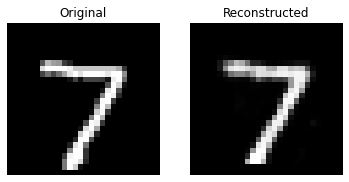

In [9]:
model.eval()
with torch.no_grad():
    sample_img, _ = test_data[0]
    sample_img = sample_img.unsqueeze(0).to(device)  # (1,1,28,28)
    z = model.encoder(sample_img)                    # latent (1,64)
    recon = model.decoder(z).view(-1, 1, 28, 28)     # (1,1,28,28)

    # Compute compression ratio
    input_size = 28 * 28
    latent_size = model.latent_dim
    compression_ratio = input_size / latent_size
    print(f"Compression Ratio: {compression_ratio:.2f}x (784 / {latent_size})")

    # Move to CPU for plotting
    orig = sample_img.squeeze().detach().cpu().numpy()
    rec  = recon.squeeze().detach().cpu().numpy()

plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(orig, cmap='gray')
plt.title('Original')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(rec, cmap='gray')
plt.title('Reconstructed')
plt.axis('off')
plt.show()


## 6) (Optional) Save & Load the Trained Model
You can save the trained weights and reload later.

In [ ]:
save_path = 'autoencoder_mnist.pt'
torch.save(model.state_dict(), save_path)
print('Saved to', save_path)

# To load later:
loaded = AutoEncoder(latent_dim=64).to(device)
loaded.load_state_dict(torch.load(save_path, map_location=device))
loaded.eval()
print('Reloaded model ready!')


## Notes & Next Steps
- Try changing `latent_dim` (e.g., 32 or 128) to see compression-quality tradeoffs.
- Increase `epochs` for better reconstructions.
- Replace the MLP with a **convolutional autoencoder** for sharper images.